## Knapsack Problem with Genetic Algorithms
This project shows how Genetic Algorithms can be used to solve complex problems like knapsack with constraints and find answers close to the optimal solution.

In [14]:
import pandas as pd
import random
import numpy as np
import statistics
import math
import matplotlib.pyplot as plt

In the cell above, the related libraries are imported for creating dataframes, plotting charts and...

In [15]:
df = pd.read_csv('snacks.csv')
items_cnt = df.shape[0]
population_size = 100
weight_sum = np.sum(df['Available Weight'])
value_sum = np.sum(df['Value'])
mutation_rate = int(0.2 * population_size)
gen_cnt = 100

The csv file is read using pandas library and some variables are set which can be changed later in order to examine how they each affect the optimality of the final solution.

In [16]:
weight_lim = int(input("weight limit: "))
value_lim = int(input("value limit: "))
[lower_lim, upper_lim] = [int(x) for x in input("lower and upper limit: ").split()]

The problem constraints are given to the program as input.

In [17]:
def init_single_chromosome(c):
    curr_items = random.randint(lower_lim, upper_lim)
    items_ind = random.sample(range(0, items_cnt), curr_items)
    chromosome = [0] * items_cnt
    for i in items_ind:
        chromosome[i] = random.uniform(0, 1)
    return chromosome

Each chromosome is a list of numbers between 0 and 1 with the length equal to the total number of items. Each fraction (gene of the chromosome) shows the fraction of the related item that we're going to take.
In the init_single_chromosome function a single chromosome is created having a random number between the lower and upper limit of genes greater than zero. The fraction between 0 and 1 is also created using a random function. This way the lower and upper limit of the number of items we can take is considered in all chromosomes of the first generation.

In [18]:
def fitness(chromosome):
    curr_items = len(chromosome) - chromosome.count(0)
    if (curr_items < lower_lim or curr_items > upper_lim): return 0
    curr_value = np.sum(np.multiply(chromosome, df['Value']))
    curr_weight = np.sum(np.multiply(chromosome, df['Available Weight']))
    value_diff = 0 if curr_value >= value_lim else value_lim - curr_value
    weight_diff = 0 if curr_weight <= weight_lim else curr_weight - weight_lim
    return weight_sum + value_sum - weight_diff - value_diff

The fitness of a chromosome is related to wether it has the right amount of items (genes greater than 0), the total weight of the items it takes and their total value.
In the fitness function if the number of taken items in a chromosome does not satisfy the limits, its fitness becomes zero since that chromosome isn't good. For a chomosome that has the right weight and value, the fitness becomes the sum of two variables, weight_sum and value_sum, which are the sum of weights and values of all the items in the snacks. For a chromosome that has too much weight or too little value, the value/weight difference with the limit is substracted from its fitness.

In [19]:
def create_first_gen():
    generation = pd.DataFrame({'Chromosomes': [None] * population_size})
    generation['Chromosomes'] = generation['Chromosomes'].apply(init_single_chromosome)
    return generation

In the create_first_gen function the first generation is created using a pandas dataframe with a single 'Chromosome' column, and the function init_single_chromosome which applies to every index of the column.

In [20]:
def sort_by_fitness():
    global generation
    generation['Fitness'] = generation['Chromosomes'].apply(lambda x: fitness(x))
    generation = generation.sort_values(by='Fitness').reset_index(drop=True)

The sort_by_fitness function adds a new column to the generation dataframe named 'Fitness' and calculates the fitness for each chromosome. Then sorts the dataframe based on the calculated fitnesses.

In [21]:
def crossover():
    global generation
    rank_list = range(population_size)
    crossover_size = math.floor(population_size/2)
    parents = random.choices(rank_list, weights=rank_list, k=population_size)
    new_generation = pd.DataFrame({'Chromosomes': [None] * population_size})
    for i in range(0, crossover_size, 2):
        crossover_point = random.randint(0, items_cnt)
        [ind1, ind2] = [parents[i], parents[i+1]]
        [parent1, parent2] = [generation['Chromosomes'].iloc[ind1], generation['Chromosomes'].iloc[ind2]]
        child1 = parent1[0:crossover_point] + parent2[crossover_point:]
        child2 = parent2[0:crossover_point] + parent1[crossover_point:]
        new_generation['Chromosomes'].iloc[i:i+2] = [child1, child2]
    for i in range(crossover_size, population_size):
        ind = parents[i]
        new_generation['Chromosomes'].iloc[i] = generation['Chromosomes'].iloc[ind]
    generation = new_generation

The crossover function ranks every chromosome by its fitness. Then chooses as many chromosomes as the population size randomly with the rank as their weight, in order to make a next generation. Half of the chosen chromosomes are crossovered with eachother and the other half go straight to the next generation. Chromosomes with higher rank are better and have higher chance of having an effect on the next generation.

In [22]:
def mutate():
    global generation
    for i in range(mutation_rate):
        chromosome = random.randint(0, population_size - 1)
        gene = random.randint(0, items_cnt - 1)
        generation['Chromosomes'].iloc[chromosome][gene] = random.uniform(0,1)

The mutate fuction chooses a fraction of the population randomly (considering the mutation rate) and changes one random gene of the chosen chromosomes randomly between 0 and 1.

In [23]:
sum_of_fitness = []
max_of_fitness = []
generation = create_first_gen()
sort_by_fitness()
for i in range(gen_cnt):
    crossover()
    mutate()
    sort_by_fitness()
    max_of_fitness = max_of_fitness + [np.max(generation['Fitness'])]
    sum_of_fitness = sum_of_fitness + [np.sum(generation['Fitness'])]

A first generation is created and sorted by fitness. Then in the for loop, the current generation is crossovered and mutated and a new generation is made. The new generation is sorted by fitness and the max fitness and sum of fitnesses of this new generation is saved in a list to be demonstrated later. This loop happens as many times as specified.

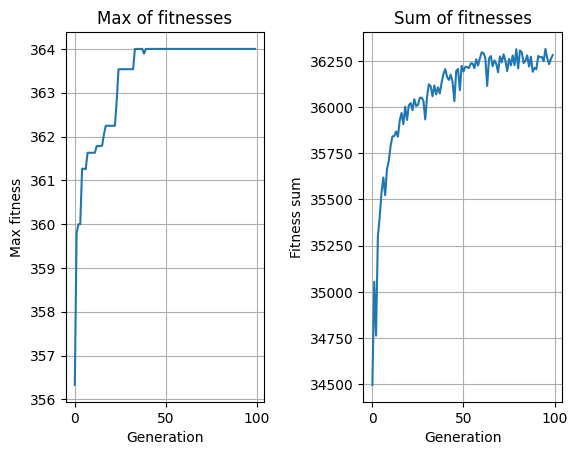

In [24]:
t = range(gen_cnt)
plt.subplot(1, 2, 1)
plt.plot(t, max_of_fitness)
plt.title('Max of fitnesses')
plt.ylabel('Max fitness')
plt.xlabel('Generation')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(t, sum_of_fitness)
plt.title('Sum of fitnesses')
plt.ylabel('Fitness sum')
plt.xlabel('Generation')
plt.grid()
plt.subplots_adjust(wspace=0.5)

In the above charts, the growth of the max fitness and sum of fitnesses over time is shown, until the semi-optimal point is reached.

In [25]:
winner = generation['Chromosomes'].iloc[-1]
items_taken = [df['Snack'].iloc[i] for i in range(len(winner)) if winner[i] != 0]
item_weights = [df['Available Weight'].iloc[i] * winner[i] for i in range(len(winner)) if winner[i] != 0]
for i in range(len(items_taken)):
    print("%s: %.2f" %(items_taken[i], item_weights[i]))

MazMaz: 0.26
Jooj: 5.39
Cookies: 3.35
Pastil: 2.25
Ghottab: 6.74


In [26]:
print("value limit: %d, value found: %.2f" %(value_lim, np.sum(np.multiply(winner, df['Value']))))
print("weight limit: %d, weight found: %.2f" %(weight_lim, np.sum(np.multiply(winner, df['Available Weight']))))

value limit: 30, value found: 30.05
weight limit: 18, weight found: 18.00
